In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# リカレントニューラルネットワークの高度な使い方

- リカレントドロップアウト    
- リカレント層のスタッキング    
- 双方向のリカレント層

## 気温予測問題

リカレント層は時系列問題も適応できる。    
http://www.bgc-jena.mpg.de/wetter/.

14種類の数値（気温、気圧、湿度、風向きなど）を10分ごとに記録した数年分のデータ。2009年から2016年を使用。最近数日分のデータを入力にして、24時間後の気温を予測するモデルを構築する。

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2018-06-24 05:20:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  23.3MB/s    in 0.6s    

2018-06-24 05:20:09 (23.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [3]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


420,551データ

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

プロットすると、気温に年単位の周期性がある。

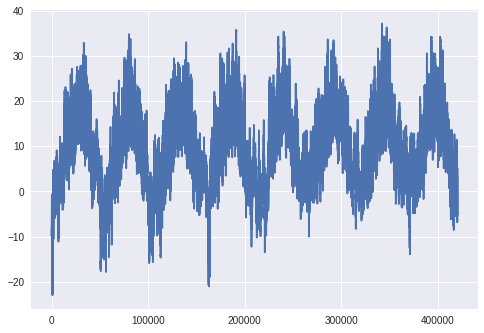

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

範囲を少し絞って、最初の１０日間の気温データをプロット。10分おきに記録されるため、1日あたり144個のデータ点。

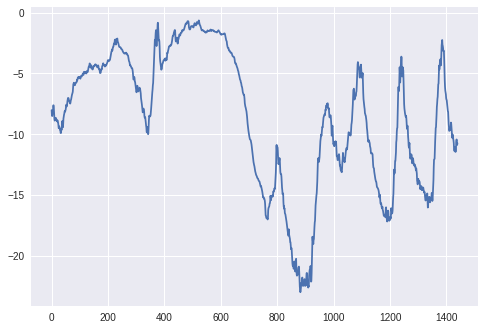

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

最後の４日間は24時間単位の周期性がある。冬のデータ。

## データの準備

lookback時間刻み（１つの時間刻みは10分）にさかのぼるデータがあり、steps時間刻みごとにサンプリングを行うとすれば、delay時間刻みの気温を予測することは可能だろうか？

パラメータは下記を使用。    

- lookback = 720...過去5日分の観測データ    
- steps = 6...観測データは1時間あたり１データ点の割合でサンプリングされる    
- delay = 144...目標値は24時間後の気温


ジェネレータを作成。ジェネレータは現在の配列を受け取り、最近のデータと目標値の将来の気温のバッチを作成する。このデータセットのサンプルはかなり冗長である（サンプルNとサンプルN+1の時間刻みのほとんどは共通）。
各サンプルを明示的に確保しておくと無駄になるので、元のデータを使ってサンプルをその場で生成する。→冗長にならないように生成したらダメなの？

    
- data = 元のデータ    
- lookback = 入力データの時間刻みをいくつさかのぼるか    
- delay = 目標値の時間刻みをいくつ進めるか    
- min_index, max_index = 抽出する時間刻みの上限と下限を表すdata配列のインデックス。データの一部を検証とテストのために取っておくのに役立つ。    
- shuffle = サンプルをシャッフルするのか、時間の順序で抽出するのか     
- step = データをサンプリングするときの期間（単位は時間刻み）。データ点を1時間ごとに１つ抽出するために６に設定。

In [3]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    #最後のindexが入ってない時の設定
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            #シャッフルなのでnp.random
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            #時系列保持なのでインデックス
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        #サンプルの雛形
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #訓練データ
            samples[j] = data[indices]
            #目標の値
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [48]:
#わかりそうでわからないコードを切り出す
import numpy as np
#min max indexは検証データを取って置く用なので意味的には無視してもいい
min_index = 1
max_index = 100
#3データさかのぼるのであれば、
lookback = 10
batch_size = 20
rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
print(rows)
print(len(rows))



[55 32 27 67 49 29 50 76 37 27 75 78 43 15 12 20 56 20 57 68]
20


In [51]:
step = 6
data = np.array([list(range(100))])
print(data.shape[-1])
print(len(rows))
print(lookback // step)
samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
targets = np.zeros((len(rows),))
#(20, 1, 100)
#2０バッチ
#訓練ラベル１
#訓練データ１００
print(samples.shape)



100
20
1
(20, 1, 100)


In [52]:
for j, row in enumerate(rows):
    indices = range(rows[j] - lookback, rows[j], step)
    print(indices)
    #訓練データ
    samples[j] = data[indices]
    #目標の値
    targets[j] = data[rows[j] + delay][1]
    print(samples[j])
    break

range(45, 55, 6)


IndexError: ignored

正規化

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

訓練ジェネレータは最初の20万個の時間刻みを調べる。検証ジェネレータは次の10万個の時間刻み、テストジェネレータは残りの時間刻みを調べる。    
    
- lookback = 720...過去5日分の観測データ    
- steps = 6...観測データは1時間あたり１データ点の割合でサンプリングされる    
- delay = 144...目標値は24時間後の気温


In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (300000 - 200001 - lookback) // batch_size

# テストデータセット全体を調べるためにtest_genから抽出する時間刻みの数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 機械学習とは別の、常識的なベースライン

ディープラーニングモデルというブラックボックスモデルを扱う前に、単純なモデルでベースラインを作る。



In [0]:
np.mean(np.abs(preds - targets))

Here's our evaluation loop:

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


MAEを0.29と算出。気温は正規化されており、中心0の標準偏差１なので、この値を見てもピンとこない。変換すると平均絶対誤差0.29+temperature_std=2.57℃になる。

## 機械学習の基本的なアプローチ



In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s - loss: 1.5009 - val_loss: 0.4131
Epoch 2/20
500/500 [==============================] - 10s - loss: 0.4272 - val_loss: 0.2994
Epoch 3/20
500/500 [==============================] - 9s - loss: 0.2837 - val_loss: 0.3115
Epoch 4/20
500/500 [==============================] - 9s - loss: 0.2629 - val_loss: 0.3213
Epoch 5/20
500/500 [==============================] - 9s - loss: 0.2486 - val_loss: 0.3156
Epoch 6/20
500/500 [==============================] - 9s - loss: 0.2405 - val_loss: 0.3144
Epoch 7/20
500/500 [==============================] - 9s - loss: 0.2351 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 9s - loss: 0.2289 - val_loss: 0.3151
Epoch 9/20
500/500 [==============================] - 9s - loss: 0.2248 - val_loss: 0.3238
Epoch 10/20
500/500 [==============================] - 9s - loss: 0.2215 - val_loss: 0.3442
Epoch 11/20
500/500 [==============================] - 9s - loss: 0.2161 - val_loss: 0.

Let's display the loss curves for validation and training:

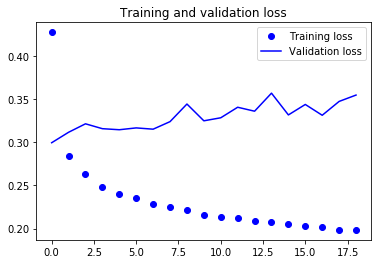

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

検証データの損失値の一部はベースラインに近づいているが確実ではない。

## 最初のリカレンとベースライン


GRUは少し効率的だがLSTMほど表現力がない場合がある。

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 169s - loss: 0.3216 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 168s - loss: 0.2846 - val_loss: 0.2654
Epoch 3/20
500/500 [==============================] - 168s - loss: 0.2772 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 168s - loss: 0.2707 - val_loss: 0.2663
Epoch 5/20
500/500 [==============================] - 168s - loss: 0.2643 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 169s - loss: 0.2584 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 168s - loss: 0.2553 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 168s - loss: 0.2508 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 165s - loss: 0.2455 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 164s - loss: 0.2423 - val_loss: 0.2801
Epoch 11/20
500/500 [==============================] - 164s - loss: 0

Let look at our results:

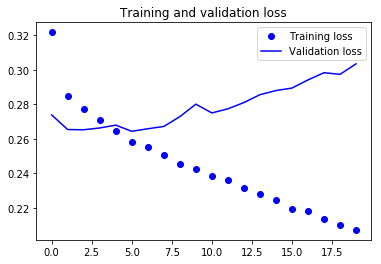

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

最大で0.265あるが、過学習になっていっている。    

MAEである2.57℃からするとよくなっているが改善の余地がある。

## リカレントドロップアウトを使って過学習を抑制する


過学習を抑制したい。リカレント層の前にドロップアウトを入れると学習の妨げになる。時間刻みごとにドロップアウトをランダムに変化させるのではなく、全ての時間刻みで同じドロップアウトを適応することで、ドロップさせるユニットのパターンを同じにすべきという論文が出てる。GRUやLSTMといった層のリカレントゲートによって形成される表現を正則化するには、時間的に一定のドロップアウトを層の内部のリカレント活性化に適応する必要がある。時間的にランダムなドロップアウトは、誤差信号を破壊してしまうので学習プロセスにとって有害。

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 171s - loss: 0.3526 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 170s - loss: 0.3138 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 170s - loss: 0.3033 - val_loss: 0.2694
Epoch 5/40
500/500 [==============================] - 170s - loss: 0.3006 - val_loss: 0.2695
Epoch 6/40
500/500 [==============================] - 170s - loss: 0.2990 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 170s - loss: 0.2955 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 170s - loss: 0.2942 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 171s - loss: 0.2940 - val_loss: 0.2649
Epoch 10/40
500/500 [==============================] - 170s - loss: 0.2923 - val_loss: 0.2673
Epoch 11/40
500/500 [==============================] - 170s - loss: 0

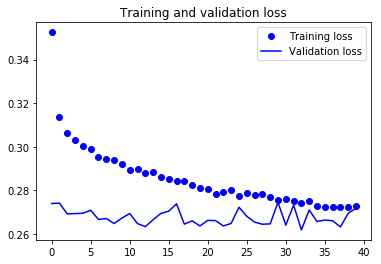

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

うまくいった。過学習は発生していない。

## リカレント層のスタッキング

性能もあげる。過学習を抑制し、モデルの表現力をあげていく。キャパシティを増やす方法はユニット数を増やすか、層の数を増やす。google translateアルゴリズムは7つの大きなLSTMのスタッキング。
スタッキングするにはreturn_sequencesをTrueにすること。

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

Let's take a look at our results:

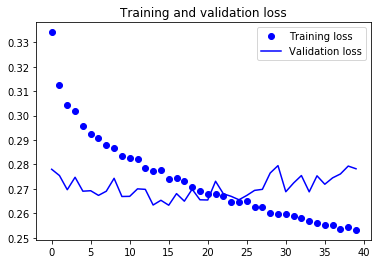

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

層を追加すると改善されるが、大きな改善にはなっていない。

## 双方向のリカレントニューラルネットワーク

双方向のRNNの方が精度が良い。RNNはNLPでよく使われる。RNNは順序に依存する。

１方向のRNNで見落とすかもしれないパターンを、双方向RNNで補足することができる。



In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s - loss: 0.4781 - val_loss: 0.4797
Epoch 2/20
500/500 [==============================] - 171s - loss: 0.4529 - val_loss: 0.4679
Epoch 3/20
500/500 [==============================] - 170s - loss: 0.4071 - val_loss: 0.4536
Epoch 4/20
500/500 [==============================] - 171s - loss: 0.3670 - val_loss: 0.4398
Epoch 5/20
500/500 [==============================] - 170s - loss: 0.3343 - val_loss: 0.4320
Epoch 6/20
500/500 [==============================] - 170s - loss: 0.3191 - val_loss: 0.4388
Epoch 7/20
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.4186
Epoch 8/20
500/500 [==============================] - 170s - loss: 0.2938 - val_loss: 0.4014
Epoch 9/20
500/500 [==============================] - 170s - loss: 0.2824 - val_loss: 0.4077
Epoch 10/20
500/500 [==============================] - 170s - loss: 0.2724 - val_loss: 0.4090
Epoch 11/20
500/500 [==============================] - 170s - loss: 0

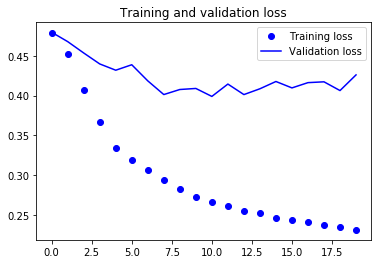

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

このGRUの性能はかなり悪い。このアプローチを成功させるには、時間の順序で処理を行うことが重要。

GRUは一般的に遠い過去よりも最近を覚えることの方が得意だが、天気データの説明変数は過去より最近の方が重要。なので普通のGRUの方が精度がいい。    

ここで重要なのはNLPと言った他の問題にも当てはまるわけではないということ。直感的にわかるように、文章を解釈するときの単語の重要度は、通常は文章内での位置に依存しない。
    
IMDbの例を見てみる。


In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 111s - loss: 0.4965 - acc: 0.7648 - val_loss: 0.3593 - val_acc: 0.8570
Epoch 2/10
20000/20000 [==============================] - 107s - loss: 0.3105 - acc: 0.8810 - val_loss: 0.3329 - val_acc: 0.8648
Epoch 3/10
20000/20000 [==============================] - 105s - loss: 0.2566 - acc: 0.9057 - val_loss: 0.3863 - val_acc: 0.8770
Epoch 4/10
20000/20000 [==============================] - 106s - loss: 0.2231 - acc: 0.9195 - val_loss: 0.3471 - val_acc: 0.8556
Epoch 5/10
20000/20000 [==============================] - 105s - loss: 0.1912 - acc: 0.9314 - val_loss: 0.3346 - val_acc: 0.8694
Epoch 6/10
20000/20000 [==============================] - 105s - loss: 0.1721 - acc: 0.9379 - val_loss: 0.3621 - val_acc: 0.8520
Epoch 7/10
20000/20000 [==============================] - 105s - loss: 0.1613 - acc: 0.9427 - val_loss: 0.3438 - val_acc: 0.8694
Epoch 8/10
20000/20000 [========================

この場合は、LSTMに匹敵する性能が得られる。
こうしたテキストデータセットでは、時間順序での処理と逆の順序の処理で性能はほぼ同じ。
「単語の順序は言語を理解するにあたって確かに重要であるものの、どちらの順序を使用するかはそれほど重要ではない」という仮説が裏付けられる。    
重要なのは、現実の世界で時間が逆行した場合の思考モデルが異なるのと同じように、逆向きのシーケンスで訓練されたRNNが、元のシーケンスで訓練されたRNNとは異なる表現を学習すること。

「アンサンブル」については7章



![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

Bidirectional層を使う。

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 214s - loss: 0.5994 - acc: 0.6865 - val_loss: 0.4722 - val_acc: 0.8090
Epoch 2/10
20000/20000 [==============================] - 213s - loss: 0.3673 - acc: 0.8543 - val_loss: 0.3769 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 213s - loss: 0.2743 - acc: 0.8972 - val_loss: 0.3196 - val_acc: 0.8688
Epoch 4/10
20000/20000 [==============================] - 211s - loss: 0.2310 - acc: 0.9150 - val_loss: 0.2972 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 211s - loss: 0.2009 - acc: 0.9261 - val_loss: 0.4461 - val_acc: 0.8514
Epoch 6/10
20000/20000 [==============================] - 210s - loss: 0.1912 - acc: 0.9339 - val_loss: 0.3636 - val_acc: 0.8640
Epoch 7/10
20000/20000 [==============================] - 209s - loss: 0.1670 - acc: 0.9423 - val_loss: 0.3476 - val_acc: 0.8580
Epoch 8/10
20000/20000 [========================

検証データでは89%ほどでLSTMよりよくなった。過学習に至るのが少し早い。Bidirectional層のパラメータの数が２倍になってるのが原因。正則化を追加すると大幅に改善される可能性がある。    

気温データに適応してみる

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 325s - loss: 0.3029 - val_loss: 0.2660
Epoch 2/40
500/500 [==============================] - 324s - loss: 0.2751 - val_loss: 0.2660
Epoch 3/40
500/500 [==============================] - 326s - loss: 0.2668 - val_loss: 0.2628
Epoch 4/40
500/500 [==============================] - 326s - loss: 0.2594 - val_loss: 0.2615
Epoch 5/40
500/500 [==============================] - 324s - loss: 0.2532 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 324s - loss: 0.2442 - val_loss: 0.2674
Epoch 7/40
500/500 [==============================] - 324s - loss: 0.2405 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 324s - loss: 0.2343 - val_loss: 0.2782
Epoch 9/40
500/500 [==============================] - 324s - loss: 0.2293 - val_loss: 0.2778
Epoch 10/40
500/500 [==============================] - 324s - loss: 0.2233 - val_loss: 0.2813
Epoch 11/40
500/500 [==============================] - 324s - loss: 0

標準的なGRUと同じ精度。理由は予測のキャパシティは全ての時間順序で処理を行うリカレント層のものに違いないから。（過去データより最近のデータの方が重要だから）


## さらに先へ進むために

気温予測問題の性能を向上させるために。

ユニット数調整、学習率調整、GRUからLSTMへ、全結合を調整


現実問題において、問題をもっともうまく解決するために具体的に何をするべきか事前に明らかになるような理論は存在しません。とにかく実践あるのみです。
